<a href="https://colab.research.google.com/github/kubernetes-world/3666-ANLP-Predicting-ECB-Monetary-Policy/blob/main/LSTM_2_scce_better.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikeras

In [ ]:
import os
import pandas as pd
import numpy as np

import gensim
import unicodedata

from itertools import groupby
from unicodedata import category as unicat

import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

from nltk import word_tokenize, pos_tag
from nltk.chunk import tree2conlltags
from nltk.chunk.regexp import RegexpParser
from nltk.corpus import wordnet as wn
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize

from sklearn.base import BaseEstimator, TransformerMixin

from tensorflow.keras.utils import pad_sequences

In [3]:

class KeyphraseExtractor(BaseEstimator, TransformerMixin):
    """
    Extract adverbial and adjective phrases, and transform
    documents into lists of these keyphrases, with a total
    keyphrase lexicon limited by the nfeatures parameter
    and a document length limited/padded to doclen
    """
    def __init__(self, nfeatures: int, doclen: int):
        self.grammar = r'KT: {(<RB.> <JJ.*>|<VB.*>|<RB.*>)|(<JJ> <NN.*>)}'
        # self.grammar = r'KT: {(<RB.*> <VB.>|<RB.>|<JJ.> <NN.*>)}'
        # self.grammar = r'KT: {<RB.>|<JJ.>}'
        self.chunker = RegexpParser(self.grammar)
        self.nfeatures = nfeatures
        self.doclen = doclen
        self._curr = 0

    def normalize(self, sent):
        """
        Removes punctuation from a tokenized/tagged sentence and
        lowercases words.
        """
        is_punct = lambda word: all(unicat(c).startswith('P') for c in word)
        sent = filter(lambda t: not is_punct(t[0]), sent)
        sent = map(lambda t: (t[0].lower(), t[1]), sent)
        return list(sent)

    def extract_candidate_phrases(self, sents, call_no):
        """
        For a document, parse sentences using our chunker created by
        our grammar, converting the parse tree into a tagged sequence.
        Extract phrases, rejoin with a space, and yield the document
        represented as a list of it's keyphrases.
        """
        print(f">> \t [{call_no}] extract_candidate_phrases...")

        for i, sent in enumerate(sents):
            tokens = word_tokenize(sent)
            pos_tags = pos_tag(tokens)
            normalized = self.normalize(pos_tags)
            # print(f"[{self._curr}] sent #{i}: {sent}")
            # print(f"[{self._curr}] \t {normalized}")

            chunks = tree2conlltags(self.chunker.parse(normalized))
            if not chunks or all(chunk[-1] == 'O' for chunk in chunks):
                #print(f"No valid chunks found in sentence: {sent}")
                continue

            phrases = [
                " ".join(word for word, pos, chunk in group).lower()
                for key, group in groupby(
                    chunks, lambda term: term[-1] != 'O'
                ) if key
            ]
            for phrase in phrases:
                yield phrase

    def fit(self, documents, y=None):
        return self

    def get_lexicon(self, keydocs):
        """
        Build a lexicon of size nfeatures
        """
        keyphrases = [keyphrase for doc in keydocs for keyphrase in doc]
        print("Keyphrases:", keyphrases[:5])
        fdist = FreqDist(keyphrases)
        counts = fdist.most_common(self.nfeatures)
        print("Frequency counts:", counts[:5])
        lexicon = [phrase for phrase, count in counts]
        return {phrase: idx+1 for idx, phrase in enumerate(lexicon)}

    def clip(self, keydoc, lexicon):
        """
        Remove keyphrases from documents that aren't in the lexicon
        """
        return [lexicon[keyphrase] for keyphrase in keydoc
            if keyphrase in lexicon.keys()]

    def transform(self, documents):
      self._curr += 1
      print(f">> [{self._curr}] KeyphraseExtractor.transform: {len(documents)}...")
      docs = [list(self.extract_candidate_phrases(doc, i)) for i, doc in enumerate(documents)]
      lexicon = self.get_lexicon(docs)
      clipped = [list(self.clip(doc, lexicon)) for doc in docs]
      return pad_sequences(clipped, maxlen=self.doclen)

In [4]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense, Input

def create_lstm_model(vocab_size: int, input_length: int, num_classes: int, compile_loss: str):
    model = Sequential([
        Input(shape=(input_length,), name="input_layer"),  # explicit input layer
        Embedding(input_dim=vocab_size, output_dim=128, name="embedding_layer"),
        LSTM(128, return_sequences=True, name="lstm_layer_1"),
        Dropout(0.2, name="dropout_layer_1"),
        LSTM(64, name="lstm_layer_2"),
        Dropout(0.2, name="dropout_layer_2"),
        Dense(num_classes, activation="softmax", name="output_layer")
    ])
    model.compile(optimizer='adam', loss=compile_loss, metrics=['accuracy'])
    return model


In [5]:
class DebugTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        print("Data Shape Before LSTM:", X.shape)
        # print("Sample Data Before LSTM:", X[0])  # print a sample
        return X


# Load prepared data and initialize `X`, `y`

In [6]:

RATE_SPEECHES_TOKENIZED_FILE = 'rate_speeches.sent_tokenize.parquet.gzip'
assert os.path.exists(RATE_SPEECHES_TOKENIZED_FILE), f"file not present: {RATE_SPEECHES_TOKENIZED_FILE}"

rate_speeches = pd.read_parquet(RATE_SPEECHES_TOKENIZED_FILE)
print(f"rate_speeches.shape: {rate_speeches.shape}")


rate_speeches.shape: (3434, 17)


It is acceptable to call `label_encoder.fit_transform(y)` on the entire set of labels (`Direction` values) because `LabelEncoder` is a simple transformation that maps categorical values to numerical labels:

- **It does not learn any information about the dataset beyond the unique classes. However, there are nuances to consider.**


In [7]:
from sklearn.preprocessing import LabelEncoder

X = rate_speeches["extracted_text"]
print(f"X.shape: {X.shape}")

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(rate_speeches["Direction"])  # integer encoding
print(f"y_encoded.shape: {y.shape}")


X.shape: (3434,)
y_encoded.shape: (3434,)


# Choices for `n_splits`

## 5-Fold Cross-Validation:
- Most commonly used.
- Provides a good balance between bias and variance of the performance estimate.

## 10-Fold Cross-Validation:
- Preferred when data is limited and computational cost is acceptable.
- Offers slightly more robust performance estimates but increases computation time.

In [8]:
from sklearn.model_selection import StratifiedKFold

# dynamically determine n_splits based on class distribution
min_class_size = rate_speeches["Direction"].value_counts().min()
print(f"min_class_size: {min_class_size}")

n_splits = min(10, min_class_size)  # use up to 10 splits or the smallest class size
print(f"Using {n_splits}-Fold Cross-Validation")

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


min_class_size: 252
Using 10-Fold Cross-Validation


In [9]:
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier
from joblib import Memory

# set up caching directory
memory_sparse = Memory(location="cache_directory_sparse", verbose=0)

pipeline_scce = Pipeline([
    ("keyphrase_extractor",
      KeyphraseExtractor(nfeatures=10000, doclen=100)),
    ('debug', DebugTransformer()),
    ("lstm_classifier",
      KerasClassifier(
        build_fn=create_lstm_model,
        vocab_size=10000,
        input_length=100,
        num_classes=3,
        compile_loss='sparse_categorical_crossentropy',
        epochs=10,
        batch_size=32,
        verbose=1)
    )
], memory=memory_sparse)


In [10]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scores = cross_val_score(pipeline_scce, X_train, y_train, cv=skf, scoring="accuracy")


>> [1] KeyphraseExtractor.transform: 2472...
>> 	 [0] extract_candidate_phrases...
>> 	 [1] extract_candidate_phrases...
>> 	 [2] extract_candidate_phrases...
>> 	 [3] extract_candidate_phrases...
>> 	 [4] extract_candidate_phrases...
>> 	 [5] extract_candidate_phrases...
>> 	 [6] extract_candidate_phrases...
>> 	 [7] extract_candidate_phrases...
>> 	 [8] extract_candidate_phrases...
>> 	 [9] extract_candidate_phrases...
>> 	 [10] extract_candidate_phrases...
>> 	 [11] extract_candidate_phrases...
>> 	 [12] extract_candidate_phrases...
>> 	 [13] extract_candidate_phrases...
>> 	 [14] extract_candidate_phrases...
>> 	 [15] extract_candidate_phrases...
>> 	 [16] extract_candidate_phrases...
>> 	 [17] extract_candidate_phrases...
>> 	 [18] extract_candidate_phrases...
>> 	 [19] extract_candidate_phrases...
>> 	 [20] extract_candidate_phrases...
>> 	 [21] extract_candidate_phrases...
>> 	 [22] extract_candidate_phrases...
>> 	 [23] extract_candidate_phrases...
>> 	 [24] extract_candidate_p

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8083 - loss: 0.6998
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8463 - loss: 0.4715
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9047 - loss: 0.2223
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9304 - loss: 0.1410
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9804 - loss: 0.0750
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9953 - loss: 0.0179
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9986 - loss: 0.0076
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9983 - loss: 0.0081
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9984 - loss: 0.0060
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9977 - loss: 0.0063
>> [2] KeyphraseExtractor.transform: 275...
>> 	 [0] extract_candidate_phrases...
>> 	 [1] extract_candidate_phrases...
>> 	 [2] extract_candidate_ph

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8122 - loss: 0.6989
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8465 - loss: 0.4636
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9055 - loss: 0.2306
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9397 - loss: 0.1371
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9796 - loss: 0.0667
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9945 - loss: 0.0219
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9947 - loss: 0.0265
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9991 - loss: 0.0092
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9974 - loss: 0.0107
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9968 - loss: 0.0143
>> [2] KeyphraseExtractor.transform: 275...
>> 	 [0] extract_candidate_phrases...
>> 	 [1] extract_candidate_phrases...
>> 	 [2] extract_candidate_phrases...
>>

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8027 - loss: 0.7103
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8479 - loss: 0.4781
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9212 - loss: 0.2294
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9753 - loss: 0.0940
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9953 - loss: 0.0188
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9959 - loss: 0.0182
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9981 - loss: 0.0077
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9995 - loss: 0.0090
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9877 - loss: 0.0555
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9972 - loss: 0.0091
>> [2] KeyphraseExtractor.transform: 275...
>> 	 [0] extract_candidate_phrases...
>> 	 [1] extract_candidate_phrases...
>> 	 [2] extract_candidate_phrases...
>>

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8113 - loss: 0.7172
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8456 - loss: 0.5328
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8791 - loss: 0.3759
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9604 - loss: 0.1435
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9922 - loss: 0.0471
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9967 - loss: 0.0218
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9988 - loss: 0.0110
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9977 - loss: 0.0144
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9976 - loss: 0.0127
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9988 - loss: 0.0056
>> [2] KeyphraseExtractor.transform: 275...
>> 	 [0] extract_candidate_phrases...
>> 	 [1] extract_candidate_phrases...
>> 	 [2] extract_candidate_phrases...
>>

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8013 - loss: 0.7353
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8499 - loss: 0.5319
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8607 - loss: 0.4318
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9437 - loss: 0.1614
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9915 - loss: 0.0420
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9958 - loss: 0.0257
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9998 - loss: 0.0054
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9989 - loss: 0.0105
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9994 - loss: 0.0059
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9988 - loss: 0.0084
>> [2] KeyphraseExtractor.transform: 275...
>> 	 [0] extract_candidate_phrases...
>> 	 [1] extract_candidate_phrases...
>> 	 [2] extract_candidate_phrases...
>>

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8115 - loss: 0.7366
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8441 - loss: 0.4893
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9148 - loss: 0.2261
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9727 - loss: 0.0909
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9966 - loss: 0.0252
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9959 - loss: 0.0233
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9986 - loss: 0.0105
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9992 - loss: 0.0052
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9987 - loss: 0.0070
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9993 - loss: 0.0045
>> [2] KeyphraseExtractor.transform: 275...
>> 	 [0] extract_candidate_phrases...
>> 	 [1] extract_candidate_phrases...
>> 	 [2] extract_candidate_phrases...
>>

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8032 - loss: 0.7306
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8330 - loss: 0.4902
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9133 - loss: 0.2006
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9370 - loss: 0.1401
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9798 - loss: 0.0672
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9932 - loss: 0.0286
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9981 - loss: 0.0103
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9958 - loss: 0.0195
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9964 - loss: 0.0153
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9970 - loss: 0.0168
>> [2] KeyphraseExtractor.transform: 275...
>> 	 [0] extract_candidate_phrases...
>> 	 [1] extract_candidate_phrases...
>> 	 [2] extract_candidate_phrases...
>>

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8134 - loss: 0.7217
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8536 - loss: 0.4788
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9086 - loss: 0.2462
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9759 - loss: 0.0959
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9915 - loss: 0.0350
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9984 - loss: 0.0090
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9991 - loss: 0.0076
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9997 - loss: 0.0028
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9965 - loss: 0.0135
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9997 - loss: 0.0023
>> [2] KeyphraseExtractor.transform: 274...
>> 	 [0] extract_candidate_phrases...
>> 	 [1] extract_candidate_phrases...
>> 	 [2] extract_candidate_phrases...
>>

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8118 - loss: 0.6880
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8445 - loss: 0.4640
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8910 - loss: 0.2199
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9496 - loss: 0.1199
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9889 - loss: 0.0487
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9960 - loss: 0.0228
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9984 - loss: 0.0087
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9989 - loss: 0.0053
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9990 - loss: 0.0044
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9989 - loss: 0.0038
>> [2] KeyphraseExtractor.transform: 274...
>> 	 [0] extract_candidate_phrases...
>> 	 [1] extract_candidate_phrases...
>> 	 [2] extract_candidate_phrases...
>>

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7984 - loss: 0.7095
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8452 - loss: 0.4756
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9121 - loss: 0.2229
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9785 - loss: 0.0985
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9896 - loss: 0.0402
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9981 - loss: 0.0165
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9973 - loss: 0.0163
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9976 - loss: 0.0121
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9976 - loss: 0.0100
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9964 - loss: 0.0111
>> [2] KeyphraseExtractor.transform: 274...
>> 	 [0] extract_candidate_phrases...
>> 	 [1] extract_candidate_phrases...
>> 	 [2] extract_candidate_phrases...
>>

In [12]:
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {np.mean(scores):.2f}")


Cross-validation scores: [0.76363636 0.77818182 0.77818182 0.78181818 0.77818182 0.78545455
 0.76363636 0.80656934 0.78832117 0.81021898]
Mean accuracy: 0.78


In [13]:

# Final Evaluation on Test Set
pipeline_scce.fit(X_train, y_train)
y_pred = pipeline_scce.predict(X_test)


>> [1] KeyphraseExtractor.transform: 2747...
>> 	 [0] extract_candidate_phrases...
>> 	 [1] extract_candidate_phrases...
>> 	 [2] extract_candidate_phrases...
>> 	 [3] extract_candidate_phrases...
>> 	 [4] extract_candidate_phrases...
>> 	 [5] extract_candidate_phrases...
>> 	 [6] extract_candidate_phrases...
>> 	 [7] extract_candidate_phrases...
>> 	 [8] extract_candidate_phrases...
>> 	 [9] extract_candidate_phrases...
>> 	 [10] extract_candidate_phrases...
>> 	 [11] extract_candidate_phrases...
>> 	 [12] extract_candidate_phrases...
>> 	 [13] extract_candidate_phrases...
>> 	 [14] extract_candidate_phrases...
>> 	 [15] extract_candidate_phrases...
>> 	 [16] extract_candidate_phrases...
>> 	 [17] extract_candidate_phrases...
>> 	 [18] extract_candidate_phrases...
>> 	 [19] extract_candidate_phrases...
>> 	 [20] extract_candidate_phrases...
>> 	 [21] extract_candidate_phrases...
>> 	 [22] extract_candidate_phrases...
>> 	 [23] extract_candidate_phrases...
>> 	 [24] extract_candidate_p

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8038 - loss: 0.6906
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8510 - loss: 0.4429
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9042 - loss: 0.2233
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9571 - loss: 0.1081
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9919 - loss: 0.0333
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9985 - loss: 0.0101
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9989 - loss: 0.0063
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9976 - loss: 0.0142
Epoch 9/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9972 - loss: 0.0111
Epoch 10/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9996 - loss: 0.0027
>> [2] KeyphraseExtractor.transform: 687...
>> 	 [0] extract_candidate_phrases...
>> 	 [1] extract_candidate_phrases...
>> 	 [2] extract_candidate_phrases...
>>

Confusion Matrix:
[[  1   3  55]
 [  4   1  45]
 [ 18  10 550]]



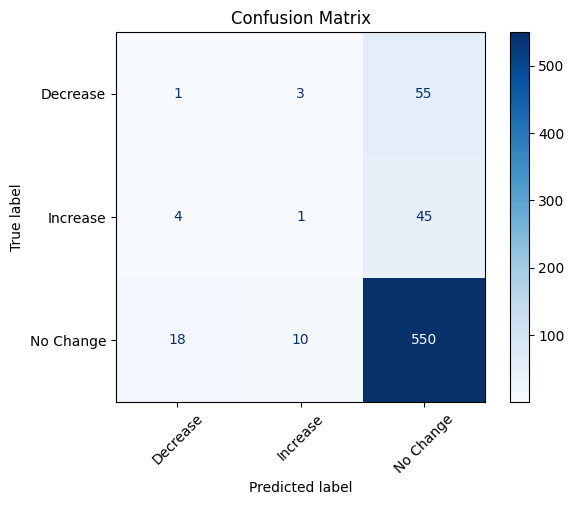


Classification Report:
              precision    recall  f1-score   support

    Decrease       0.04      0.02      0.02        59
    Increase       0.07      0.02      0.03        50
   No Change       0.85      0.95      0.90       578

    accuracy                           0.80       687
   macro avg       0.32      0.33      0.32       687
weighted avg       0.72      0.80      0.76       687



In [15]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=range(len(label_encoder.classes_)))
print(cm)

print()
# display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

print()
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))